### Введение.


Требуется провести на небольшой выборке клиентов федерального оператора сотовой связи «Мегалайн» предварительный анализ тарифных планов «Смарт» и «Ультра». Целью анализа является выяснение прибылности тарифных планов для корректировки рекламного бюджета. В распоряжении данные 500 пользователей «Мегалайна». Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:

Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей
   
Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 1 рубль
  - сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей
  
Исходные данные:

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц,  то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Шаг 1.

Импорт библиотек и данных, вывод общей информации о таблицах.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from scipy import stats as st
import warnings

from io import BytesIO
import requests

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 35)

In [2]:
def data_from_g_sheets(spreadsheet_id):
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    return pd.read_csv(BytesIO(r.content))

In [3]:
try:
    
    calls = data_from_g_sheets('1jvjunML6ExJ53Kk4boVM7eQzXoFMQrgyIQCi2zYuy8w')
    internet = data_from_g_sheets('1wXmFmzJpKkUhSxBrAHfNRe8k6zac3M6e4vdPV77kf_4')
    messages = data_from_g_sheets('1xsDjTw96dmg-_jCqUojHH50_kJn8_7roDXCwNqfSVHc')
    tariffs = data_from_g_sheets('1k9sUl-groxFcYvhvVXuyjMxeWZEF9Trc8fh2BojFNRc')
    users = data_from_g_sheets('12OiT5k0Dn4Xms1Y7iQHpnYC2Sia0r_mvJrT-YDMeWmk')
        
except:
        
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

In [4]:
display(calls.info())
display(calls.head(10))

display(internet.info())
display(internet.head(10))

display(messages.info())
display(messages.head(10))

display(tariffs.info())
display(tariffs.head(10))

display(users.info())
display(users.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


### Шаг 2. Предобработка и подготовка данных.

###### Шаг 2.1. Предобработка данных.

В таблице `calls` пропуски и дубликаты отсутствуют, столбец `call_date` приводим к типу `datetime64[ns]`.

In [5]:
# преобразование типа данных в столбце call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

В столбце `duration` присутствует `39613` записей с значением `0,00`, что составляет примерно `19,5%` от всех записей. Удаляем.

In [6]:
calls = calls.query('duration != "0.00"').reset_index(drop = True)
#calls = calls[~(calls['duration'] == "0.00")].reset_index(drop = True)

В таблице `internet` пропуски и дубликаты отсутствуют. Столбец `Unnamed: 0` удален, так как не несет смысловой нагрузки (значения в этом столбце повторяют значения в столбце `index`). Столбец `session_date` приводим к типу `datetime64[ns]`

In [7]:
# удаление столбца Unnamed: 0
internet = internet.drop(columns = ['Unnamed: 0'])

# преобразование типа данных в столбце session_date
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

В таблице `messages` пропуски и дубликаты отсутствуют, столбец `message_date` приводим к типу `datetime64[ns]`

In [8]:
# преобразование типа данных в столбце message_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

В таблице `tariffs` переименовываем столбец `tariff_name` в `tariff`

In [9]:
# переименование столбца tariff_name в tariff
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']

В таблице `users` дубликаты отсутствуют. Столбец `churn_date` приводим к типу `datetime64[ns]`, пропуски оставляем. Столбец `reg_date` приводим к типу `datetime64[ns]`. Создаем столбцы `churn_month` и `reg_month` с указанием месяца.

In [10]:
# преобразование типа данных в столбце churn_date
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
# преобразование типа данных в столбце reg_date
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
# создание столбца churn_month в котором сохраняется только месяц из churn_date
users['churn_month'] = users['churn_date'].dt.month
# создание столбца reg_month в котором сохраняется только месяц из reg_date
users['reg_month'] = users['reg_date'].dt.month

###### Шаг 2.2. Подготовка, группировка данных.

Расчет количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

In [11]:
# создание столбца month в котором сохраняется только месяц из call_date
calls['month'] = calls['call_date'].dt.month
# округление значений столбца duration в большую сторону
display(calls.head())
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int64')
display(calls.head())
# создание таблицы с суммой минут и кол-ом звонков, сгруппированой по паре столбцов: user_id + month
calls_grp = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['sum', 'count']).reset_index()
# переименование столбцов (удаление двойных названий столбцов)
calls_grp.columns = ['user_id', 'month', 'sum_calls_minute', 'count_calls']


#calls_grp['sum_calls_minute'] = calls_grp['sum_calls_minute'] + np.ceil(1)
#calls_grp['sum_calls_minute'] = calls_grp['sum_calls_minute'].astype('int64')

,id,call_date,duration,user_id,month
0,1000_2,2018-06-11,2.85,1000,6
1,1000_3,2018-09-21,13.80,1000,9
2,1000_4,2018-12-15,5.18,1000,12
3,1000_7,2018-08-22,18.31,1000,8
4,1000_8,2018-09-15,18.44,1000,9


,id,call_date,duration,user_id,month
0,1000_2,2018-06-11,3,1000,6
1,1000_3,2018-09-21,14,1000,9
2,1000_4,2018-12-15,6,1000,12
3,1000_7,2018-08-22,19,1000,8
4,1000_8,2018-09-15,19,1000,9


Рассчет количества отправленных сообщений по месяцам для каждого пользователя

In [12]:
# создание столбца month в котором сохраняется только месяц из message_date
messages['month'] = messages['message_date'].dt.month
# создание таблицы с кол-ом сообщений, сгруппированой по паре столбцов: user_id + month
messages_grp = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count').reset_index()
# переименование столбцов
messages_grp.columns = ['user_id', 'month', 'count_messages']

Рассчет объема израсходованного интернет-трафика по месяцам для каждого пользователя

In [13]:
# создание столбца month в котором сохраняется только месяц из session_date
internet['month'] = internet['session_date'].dt.month

display(internet.head())
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int64')
display(internet.head())


# создание таблицы с кол-ом использованного трафика, сгруппированой по паре столбцов: user_id + month
internet_grp = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum').reset_index()

#internet_grp['mb_used'] = internet_grp['mb_used'] + np.ceil(1)
#internet_grp['mb_used'] = internet_grp['mb_used'].astype('int64')


,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


Объединение таблиц `calls_grp`, `messages_grp`, `internet_grp`, в `data` 

In [14]:
# объединение по столбцам user_id и month
data = calls_grp.merge(messages_grp, on = ['user_id', 'month'], how = 'outer')
data = data.merge(internet_grp, on = ['user_id', 'month'], how = 'outer')
users = users[['user_id', 'city', 'tariff']]
data = data.merge(users, on = 'user_id', how = 'outer')

Объдинение таблиц `data` и `tariffs`

In [15]:
# объединение по столбцу tariff
data = data.merge(tariffs, on = 'tariff', how = 'outer')

Расчет помесячной выручки с каждого пользователя. Необходимо учеть расход входищих в тариф лимитов.

In [16]:
data['month'] = data['month'].fillna(data['month'].median())
data['month'] = data['month'].astype('int64')
data['sum_calls_minute'] = data['sum_calls_minute'].fillna(0)
data['sum_calls_minute'] = data['sum_calls_minute'].astype('int64')
data['count_calls'] = data['count_calls'].fillna(0)
data['count_calls'] = data['count_calls'].astype('int64')
data['count_messages'] = data['count_messages'].fillna(0)
data['count_messages'] = data['count_messages'].astype('int64')
data['mb_used'] = data['mb_used'].fillna(0)
data['mb_used'] = data['mb_used'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                3216 non-null   int64 
 1   month                  3216 non-null   int64 
 2   sum_calls_minute       3216 non-null   int64 
 3   count_calls            3216 non-null   int64 
 4   count_messages         3216 non-null   int64 
 5   mb_used                3216 non-null   int64 
 6   city                   3216 non-null   object
 7   tariff                 3216 non-null   object
 8   messages_included      3216 non-null   int64 
 9   mb_per_month_included  3216 non-null   int64 
 10  minutes_included       3216 non-null   int64 
 11  rub_monthly_fee        3216 non-null   int64 
 12  rub_per_gb             3216 non-null   int64 
 13  rub_per_message        3216 non-null   int64 
 14  rub_per_minute         3216 non-null   int64 
dtypes: int64(13), object(

Добавление в таблицу `data` столбца `minutes_paid` с платой за минуты для каждого пользователя. Если пользователь не выговорил включенные в тариф минуты, и получается отрицалельная стоимость, таким значениям присваивается `0`

In [17]:
# расчет оплаты минут сверх лимита
data['minutes_paid'] = (data['sum_calls_minute'] - data['minutes_included']) * data['rub_per_minute']
# если пользователь не вышел из лимита минут включенных в тариф, оператор "прощает" пользователю остаток, присваиваем 0
data.loc[(data['minutes_paid'] < 0, 'minutes_paid')] = 0

Добавление в таблицу `data` столбца `messages_paid` с платой за сообщения для каждого пользователя. Если пользователь не потратил включенные в тариф сообщения, и получается отрицалельная стоимость, таким значениям присваиеватся `0`

In [18]:
# расчет оплаты сообщений сверх лимита
data['messages_paid'] = (data['count_messages'] - data['messages_included']) * data['rub_per_message']
# если пользователь не вышел из лимита сообщений включенных в тариф, оператор "прощает" пользователю остаток, присваиваем 0
data.loc[(data['messages_paid'] < 0, 'messages_paid')] = 0

Добавление в таблицу `data` столбца `gb_paid` с платой за интернет - трафик для каждого пользователя. Если пользователь не потратил включенный в тариф интернет - трафик, и получается отрицалельная стоимость, таким значениям присваивается `0`

In [19]:
# расчет оплаты трафика сверх лимита
data['gb_paid'] = (data['mb_used'] - data['mb_per_month_included']) * data['rub_per_gb'] / 1024
# если пользователь не вышел из лимита трафика включенного в тариф, оператор "прощает" пользователю остаток, присваиваем 0
data.loc[data['gb_paid'] < 0, 'gb_paid'] = 0

Добавление в таблицу `data` столбца `user_paid` с помесячной выручкой с каждого пользователя

In [20]:
# складываем произведенные ранее расчеты + абонентскую плату
data['user_paid'] = (data['minutes_paid'] + data['messages_paid'] + data['gb_paid'] + data['rub_monthly_fee']).round(2)

### Предобработка данных. Вывод:

- В таблице `calls` пропуски и дубликаты отсутствуют, столбец `call_date` привел к типу `datetime64[ns]`. В столбце `duration` обнаружилось `39613` записей с значением `0,00`, что составляет примерно `19,5%` от всех записей. Посчитал целесообразным данные удалить, смысловой нагрузки не несут;
- В таблице `internet` пропуски и дубликаты отсутствуют. Столбец `Unnamed: 0` удален, так как не несет смысловой нагрузки (значения в этом столбце повторяли значения в столбце `index`). Столбец `session_date` привел к типу `datetime64[ns]`;
- В таблице `messages` пропуски и дубликаты отсутствуют, столбец `message_date` привел к типу `datetime64[ns]`;
- В таблице `tariffs` переименовал столбец `tariff_name` в `tariff`;
- В таблице `users` дубликаты отсутствуют. Столбец `churn_date` привел к типу `datetime64[ns]`, пропуски оставил. Столбец `reg_date` привел к типу `datetime64[ns]`. Создал столбцы `churn_month` и `reg_month` с указанием месяца;

Произвел рассчет по месяцам для каждого пользователя:
- количества сделанных звонков;
- израсходованных минут разговора;
- отправленных сообщений;
- объема израсходованного интернет-трафика; 

Указанные расчеты и данные по тарифам, объединил в таблицу `data`. Так же произведен рассчет помесяцной выручки с каждого пользователя, в расчете учтены входящие в тарифы лимиты.

### Шаг 3. Анализ данных.

Создание таблиц с тарифоми смарт и ультра

In [21]:
tariff_smart = data.query('tariff == "smart"').reset_index(drop = True)

In [22]:
tariff_ultra = data.query('tariff == "ultra"').reset_index(drop = True)

Изучение выбросов в доходе с пользователй (`user_paid`) для тарифов. 

Диаграмма размаха для тарифа Смарт:


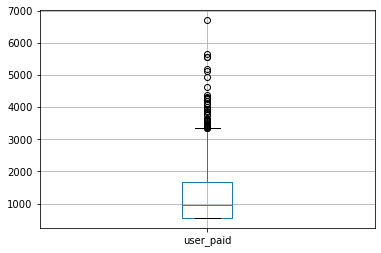

Диаграмма размаха для тарифа Ультра:


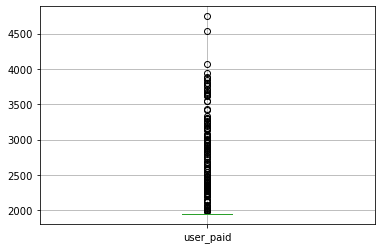

In [23]:
print('Диаграмма размаха для тарифа Смарт:')    
tariff_smart.boxplot('user_paid')
plt.show()
print('Диаграмма размаха для тарифа Ультра:')
tariff_ultra.boxplot('user_paid')
plt.show()

Рассчет размахов "усов" для `user_paid` для исключения редких и выбивающихся значений, находящихся за пределами "усов". Создание таблиц `smart_good_data` и `ultra_good_data` без редких и выбивающихся значений.

In [24]:
#расчет левого и правого уса для user_paid в тарифе Смарт
smart_user_paid_low_wi = tariff_smart['user_paid'].quantile(0.25) - ((tariff_smart['user_paid'].quantile(0.75) - tariff_smart['user_paid'].quantile(0.25)) * 1.5)
#smart_user_paid_high_wi = tariff_smart['user_paid'].quantile(0.75) + ((tariff_smart['user_paid'].quantile(0.75) - tariff_smart['user_paid'].quantile(0.25)) * 1.5)
# за верхнюю границу выбросов посчитал целесообразным взять 95-й перцентиль 
smart_user_paid_high_wi = tariff_smart['user_paid'].quantile(0.95)
#создание таблицы smart_good_data без выбивающихся значений user_paid
smart_good_data = tariff_smart.query('(user_paid > @smart_user_paid_low_wi) and (user_paid < @smart_user_paid_high_wi)')                                                                                                           

In [25]:
#расчет левого и правого уса для user_paid в тарифе Ультра
ultra_user_paid_low_wi = tariff_ultra['user_paid'].quantile(0.25) - ((tariff_ultra['user_paid'].quantile(0.75) - tariff_ultra['user_paid'].quantile(0.25)) * 1.5)
#ultra_user_paid_high_wi = tariff_ultra['user_paid'].quantile(0.75) + ((tariff_ultra['user_paid'].quantile(0.75) - tariff_ultra['user_paid'].quantile(0.25)) * 1.5)
# за верхнюю границу выбросов посчитал целесообразным взять 95-й перцентиль 
ultra_user_paid_high_wi = tariff_ultra['user_paid'].quantile(0.95)
#создание DataFrame good_data без редких и выбивающихся значений
ultra_good_data = tariff_ultra.query('(user_paid >= @ultra_user_paid_low_wi) and (user_paid <= @ultra_user_paid_high_wi)')  

Расчет дисперсии для значений столбцов `count_messages`, `sum_calls_minute`, `mb_used` для соответсвующих тарифов Смарт и Ультра.

In [26]:
print('Тариф Смарт:')
variance_count_messages_smart = np.var(smart_good_data['count_messages'], ddof=0)
#variance_count_messages_smart = mt.sqrt(variance_count_messages_smart)
print('Дисперсия для кол-ва сообщения:', variance_count_messages_smart)

variance_sum_calls_minute_smart = np.var(smart_good_data['sum_calls_minute'], ddof=0)
#variance_sum_calls_minute_smart = mt.sqrt(variance_sum_calls_minute_smart)
print('Дисперсия для кол-ва минут:', variance_sum_calls_minute_smart)

variance_mb_used_smart = np.var(smart_good_data['mb_used'], ddof=0)
#variance_mb_used_smart = mt.sqrt(variance_mb_used_smart)
print('Дисперсия для объема трафика:', variance_mb_used_smart)

print()
print('Тариф Ультра:')
variance_count_messages_ultra = np.var(ultra_good_data['count_messages'], ddof=0)
#variance_count_messages_ultra = mt.sqrt(variance_count_messages_ultra)
print('Дисперсия для кол-ва сообщения:', variance_count_messages_ultra)

variance_sum_calls_minute_ultra = np.var(ultra_good_data['sum_calls_minute'], ddof=0)
#variance_sum_calls_minute_ultra = mt.sqrt(variance_sum_calls_minute_ultra)
print('Дисперсия для кол-ва минут:', variance_sum_calls_minute_ultra)

variance_mb_used_ultra = np.var(ultra_good_data['mb_used'], ddof=0)
#variance_mb_used_ultra = mt.sqrt(variance_mb_used_ultra)
print('Дисперсия для объема трафика:', variance_mb_used_ultra)





Тариф Смарт:
Дисперсия для кол-ва сообщения: 770.2230363242833
Дисперсия для кол-ва минут: 33480.0955907857
Дисперсия для объема трафика: 28712962.848891754

Тариф Ультра:
Дисперсия для кол-ва сообщения: 2213.5092307235773
Дисперсия для кол-ва минут: 99522.66937755643
Дисперсия для объема трафика: 81546617.77276354


Создание сводной таблицы с исключенными выбросами по оплате `user_paid` в тарифах Смарт и Ультра

In [27]:
good_data = data.query('(tariff == "smart" and ((user_paid > @smart_user_paid_low_wi) and (user_paid < @smart_user_paid_high_wi))) or (tariff == "ultra" and (user_paid >= @ultra_user_paid_low_wi) and (user_paid <= @ultra_user_paid_high_wi))')

Создание отчетной таблицы кол-ва минут разговора, сообщений и объёма интернет-трафика, требубщихся пользователям каждого тарифа по месяцам 

In [28]:
report_0 = good_data.pivot_table(index = ['tariff', 'month'], values = ['sum_calls_minute', 'count_messages', 'mb_used'], aggfunc = 'mean').round().astype('int64')
display(report_0)

count_messages  mb_used  sum_calls_minute
tariff month                                           
smart  1                  18     8524               204
       2                  24    11315               294
       3                  32    15124               390
       4                  31    13357               367
       5                  34    15480               387
       6                  33    15514               390
       7                  34    15173               406
       8                  33    16120               417
       9                  33    15830               421
       10                 34    15934               417
       11                 34    16486               424
       12                 36    16941               453
ultra  1                  34    13154               428
       2                  22    11787               297
       3                  33    17002               500
       4                  32    16468               462
       5                  38    18265               508
       6                  42    17900               471
       7                  51    18398               550
       8                  50    18706               508
       9                  52    18692               529
       10                 58    19139               550
       11                 55    18464               527
       12                 60    19841               591

Рассчет среднего количества и стандартного отклонения для минут разговора, сообщений и объёма интернет-трафика для каждого тарифа

In [29]:
report_1 = good_data.pivot_table(index = ['user_id', 'month'], values = ['sum_calls_minute', 'count_messages', 'mb_used'], columns = ['tariff'])
report_1 = report_1.describe().swaplevel(0, 1, axis = 1).sort_index(axis = 1)
display(report_1.loc[['mean', 'std']].T.round().astype('int64'))

mean   std
tariff                              
smart  count_messages       33    28
       mb_used           15626  5360
       sum_calls_minute    408   183
ultra  count_messages       49    47
       mb_used           18328  9035
       sum_calls_minute    521   316

Вывод гистограмм распределения минут разговора, кол-ва сообщений, объема трафика, дохода с пользователей

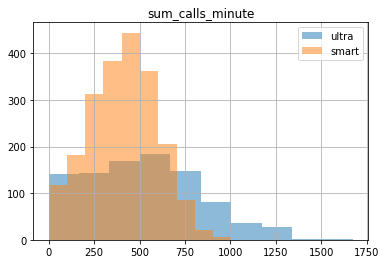

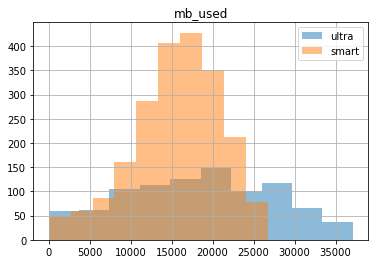

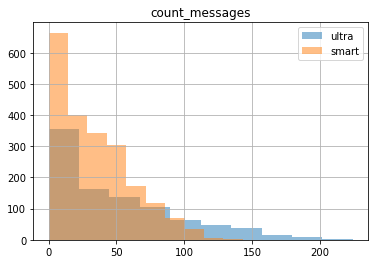

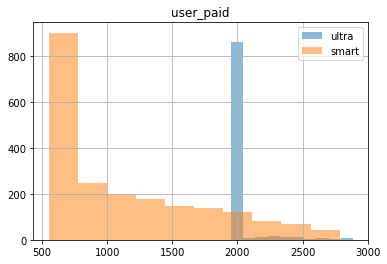

In [30]:
data_hist = good_data.copy()
for element in ['sum_calls_minute', 'mb_used', 'count_messages', 'user_paid']:
    for tariff_name in data_hist['tariff'].unique():
        (data_hist.query('tariff == @tariff_name')[element].hist(bins = 10, alpha = 0.5, label = tariff_name))
    plt.title(element)
    plt.legend()
    plt.show()

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [31]:
display(tariffs.head(10))
display(report_1.loc[['mean', 'std']].T.round().astype('int64'))

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


mean   std
tariff                              
smart  count_messages       33    28
       mb_used           15626  5360
       sum_calls_minute    408   183
ultra  count_messages       49    47
       mb_used           18328  9035
       sum_calls_minute    521   316

### Анализ данных. Вывод:

Удалены выбросы по значениям дохода с пользователя, которые присутствовали в выборке по тарифам Смарт и Ультра. В соответствии с отчетной таблицей кол-ва минут разговора, сообщений и объёма интернет-трафика, требубщихся пользователям каждого тарифа по месяцам, прослеживается тенденция того, что не смотря на тарифный план, пользователи к концу года больше портебляют услуг оператора в отличие от начала года. Из расчета среднего, можно сделать вывод, что пользователи тарифа Ультра больше разговариают по телефону, отправляют сообщений и тратят интернет-трафика. Однако, из расчета среднего и дисперии можно сделать вывод, что данные тарифа Ультра в части минут, сообщений и трафика больше "размазаны" вокруг среднего в отличие от тех же данных тарифа Смарт. Это указывает на некоторую неопределенность в данных тарифа Ультра.

<font color='purple'>></font>
Стоит отметить, что пользователи тарифа Смарт в среднем укладываются в предоставленные им лимты, но и так же есть пользователи, которые лимиты превышают, особенно в части интернет - трафика и сообщений. Противоположная ситуация с пользователями тарифа Ультра: предоставленных лимитов более чем достаточно, даже самые активные пользователи лимиты не превышают.

### Шаг 4. Проверка гипотез.

Проверка гипотезы. 
- Формулировка нулевой гипотезы: средняя выручка пользователей тарифа Смарт равна средней выручке пользователей тарифа Ультра. Формулировка альтернативной гипотезы: средняя выручка пользователей тарифа Смарт не равна средней выручке пользователей тарифа Ультра

In [32]:
alpha = 0.01 
results = st.ttest_ind(smart_good_data['user_paid'], ultra_good_data['user_paid'])

print('p-значение:', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.81e-321
Отвергаем нулевую гипотезу


Проверка гипотезы. 
- Формулировка нулевой гипотезы: средняя выручка тарифа Смарт пользователей из Москвы равна средней выручки тарифа Смарт пользователей из других регионов. Формулировка альтернативной гипотезы: средняя выручка тарифа Смарт пользователей из Москвы не равна средней выручки тарифа Смарт пользователей из других регионов

In [33]:
# Создание таблиц с пользователями из москвы и с пользователями не из москвы для тарифа смарт
smart_good_data_moscow = smart_good_data.query('city == "Москва"')
smart_good_data_not_moscow = smart_good_data.query('city != "Москва"')

In [34]:
alpha = 0.01 
results = st.ttest_ind(smart_good_data_not_moscow['user_paid'], smart_good_data_moscow['user_paid'])

print('p-значение:', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.17463061160398982
Не получилось отвергнуть нулевую гипотезу


Проверка гипотезы. 
- Формулировка нулевой гипотезы: средняя выручка тарифа Ультра пользователей из Москвы равна средней выручки тарифа Ультра пользователей из других регионов. Формулировка альтернативной гипотезы: редняя выручка тарифа Ультра пользователей из Москвы не равна средней выручки тарифа Ультра пользователей из других регионов

In [35]:
# Создание таблиц с пользователями из москвы и с пользователями не из москвы для тарифа ультра
ultra_good_data_moscow = ultra_good_data.query('city == "Москва"')
ultra_good_data_not_moscow = ultra_good_data.query('city != "Москва"')

In [36]:
alpha = 0.01 
results = st.ttest_ind(ultra_good_data_moscow['user_paid'], ultra_good_data_not_moscow['user_paid'])# ваш код: проверьте гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.16033023754599893
Не получилось отвергнуть нулевую гипотезу


### Проверка гипотез. Вывод:

В сответствии с результатом проверки гипотез, можно сделать вывод, что:

- средняя выручка пользователей тарифа Смарт не равна средней выручке пользователей тарифа Ультра. Более того, выручка тарифа Ультра практически в 2 раза выше выручки тарифа Смарт;
- средняя выручка тарифа Смарт пользователей из Москвы равна средней выручки тарифа Смарт пользователей из других регионов;
- средняя выручка тарифа Ультра пользователей из Москвы равна средней выручки тарифа Ультра пользователей из других регионов;

Одновременно с этим, стоит отметить, что размер выручки как с тарифа Смарт, так и с тарифа Ультра не зависит от того находится ли пользователь в Москве или другом регионе, где предоставляет услуги связи опертор Мегалайн.

### Шаг 5. Общий вывод:

Был проведен предварительный анализ тарифных планов «Смарт» и «Ультра». 

Произведен рассчет для каждого пользователя по месяцам:
- количества сделанных звонков;
- израсходованных минут разговора;
- отправленных сообщений;
- объема израсходованного интернет-трафика; 

В соответствии со сводной информацией и расчетами:
- прослеживается тенденция того, что не смотря на тарифный план, пользователи к концу года больше портебляют услуг оператора в отличие от начала года;
- пользователи тарифа Ультра больше разговариают по телефону, отправляют сообщений и тратят интернет-трафика в отличие от пользователей тарифа Смарт; 
- данные тарифа Ультра в части минут, сообщений и трафика больше "размазаны" вокруг среднего значения в отличие от тех же данных тарифа Смарт. Это указывает на некоторую неопределенность в данных тарифа Ультра;

Были проверены и отвергнуты следующие гипотезы:
- средняя выручка пользователей тарифа Смарт равна средней выручке пользователей тарифа Ультра;
- средняя выручка тарифа Смарт пользователей из Москвы не равна средней выручки тарифа Смарт пользователей из других регионов;
- средняя выручка тарифа Ультра пользователей из Москвы не равна средней выручки тарифа Ультра пользователей из других регионов;

Как итог, стоит отметить, что не смотря на то, что пользователи тарифа Смарт иногда превышают предоставленные им лимиты по количеству сообщений, минутам разговора, а в особенности интернет - трафику, и переплачивают за это сверх абонентской платы, тем не меннее, тариф Ультра более выгоден для оператора Мегалайн. Так же стоит обратить внимание, что размер выручки как с тарифа Смарт, так и с тарифа Ультра не зависит от того находится ли пользователь в Москве или другом регионе, где предоставляет свои услуги связи опертор Мегалайн.